In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import os
import imageio
import cv2
import shutil
from zipfile import ZipFile
import shutil
from keras.applications import resnet
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,Conv2D,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf 

In [3]:
!nvidia-smi

Tue Apr 11 15:17:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0               13W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Dataset Exploration

In [7]:
if os.path.exists('./data_resampled') and (os.path.exists('./data_resampled/train') or os.path.exists('./data_resampled/test')):
    shutil.rmtree('./data_resampled')

if (os.path.exists('./data/train') and os.path.exists('./data/test'))==False:    
    print('Unzipping')
    with ZipFile('./data_archive.zip', 'r') as zObject:
        zObject.extractall(path='./data/')
    print('Unzipping Done')

In [8]:
train_path ='./data/train/'
test_path ='./data/test/'

categories = os.listdir(train_path)

df = pd.DataFrame(categories,columns=['Emotions'])
train_count = []
test_count = []

for path in [train_path,test_path]: 
    for cat in categories:
        
        current_path = os.listdir(path+cat)
        if path == train_path:
            train_count.append(len(current_path))
            
        elif path == test_path:
            test_count.append(len(current_path))
            
df['Train_images_count'] = train_count
df['Test_images_count'] = test_count
display(df)

,Emotions,Train_images_count,Test_images_count
0,angry,3995,958
1,disgust,436,111
2,fear,4097,1024
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
6,surprise,3171,831


Emotion:  angry
(48, 48, 3)


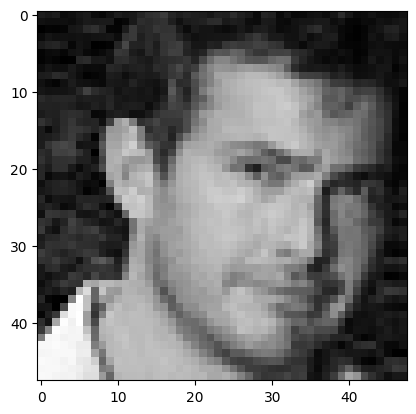

Emotion:  disgust
(48, 48, 3)


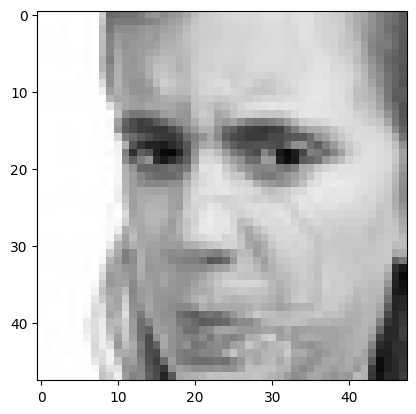

Emotion:  fear
(48, 48, 3)


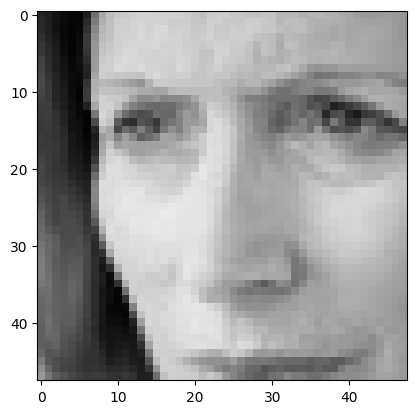

Emotion:  happy
(48, 48, 3)


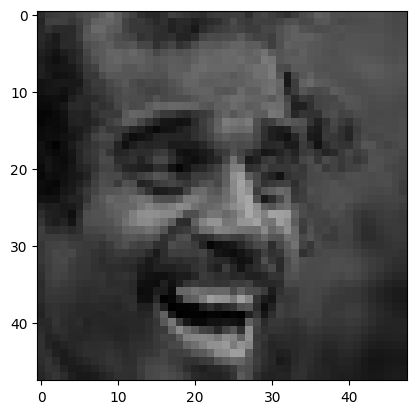

Emotion:  neutral
(48, 48, 3)


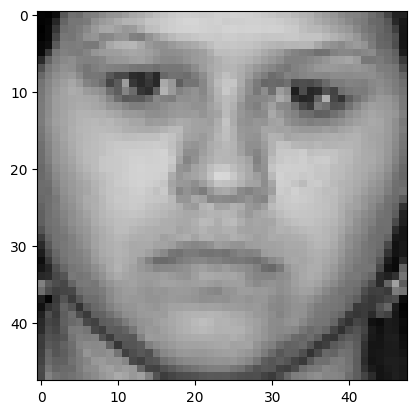

Emotion:  sad
(48, 48, 3)


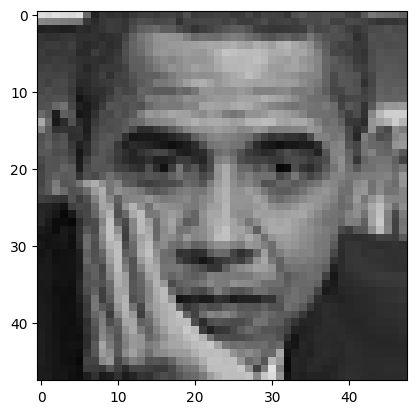

Emotion:  surprise
(48, 48, 3)


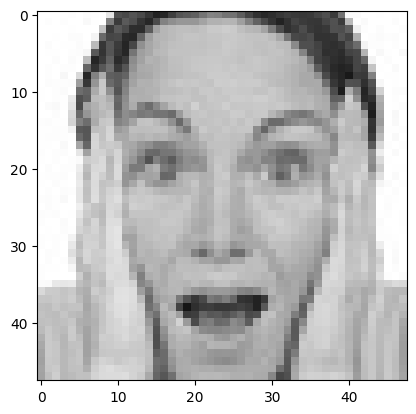

In [9]:
# Viewing Sample images from train set

for cat in categories:
    print("Emotion: ",cat)
    image = cv2.imread(train_path+cat+'/'+(os.listdir(train_path+cat)[1]))
    print(image.shape)
    plt.imshow(image)
    plt.show()

Emotion:  angry


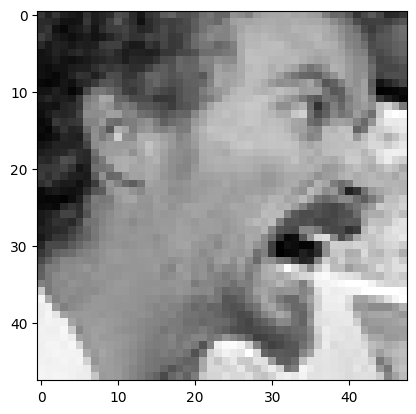

Emotion:  disgust


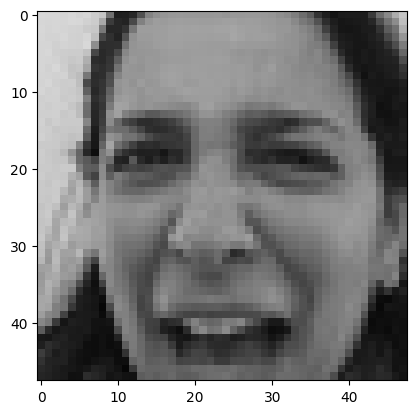

Emotion:  fear


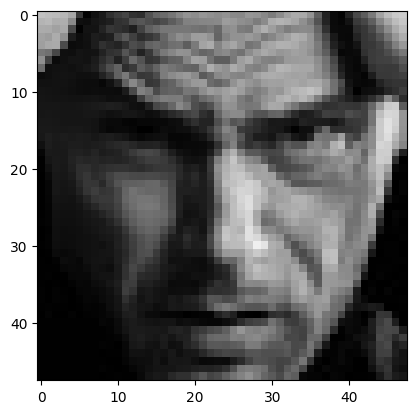

Emotion:  happy


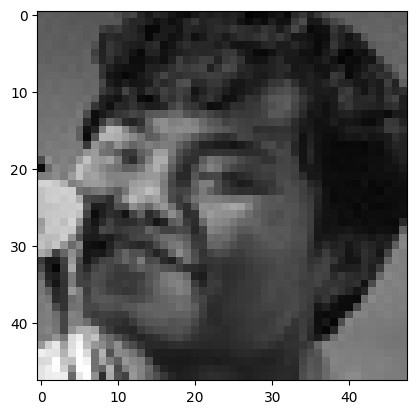

Emotion:  neutral


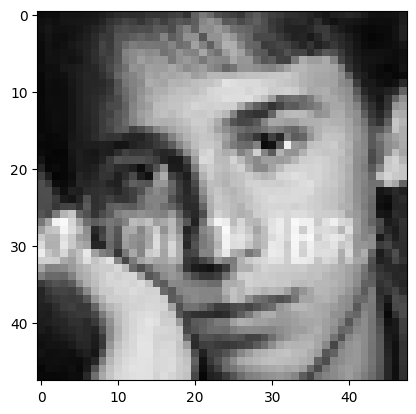

Emotion:  sad


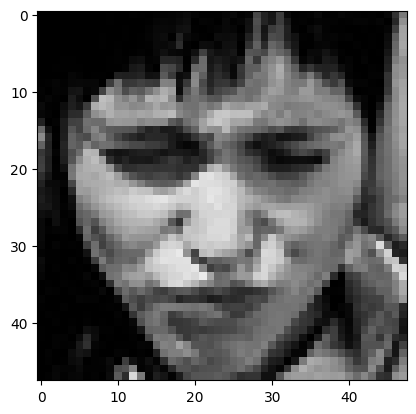

Emotion:  surprise


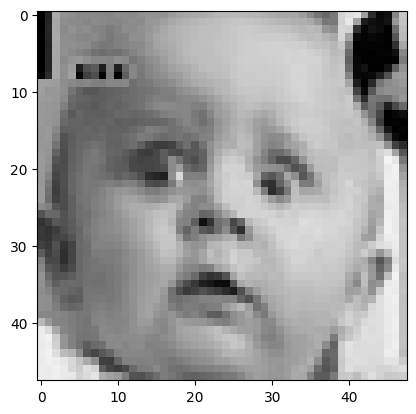

In [10]:
# Viewing Sample images from test set

for cat in categories:
    print("Emotion: ",cat)
    image = cv2.imread(test_path+cat+'/'+(os.listdir(test_path+cat)[1]))
    plt.imshow(image)
    plt.show()

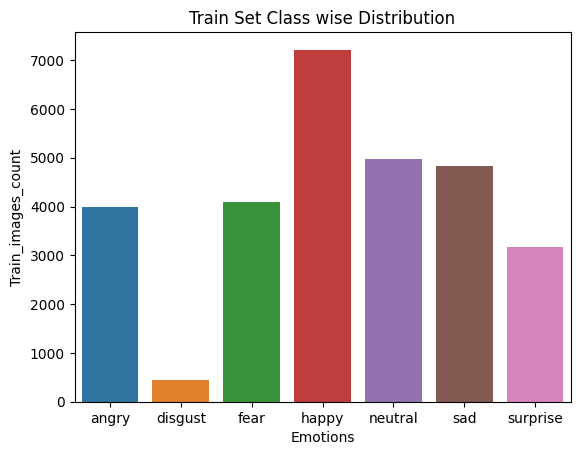

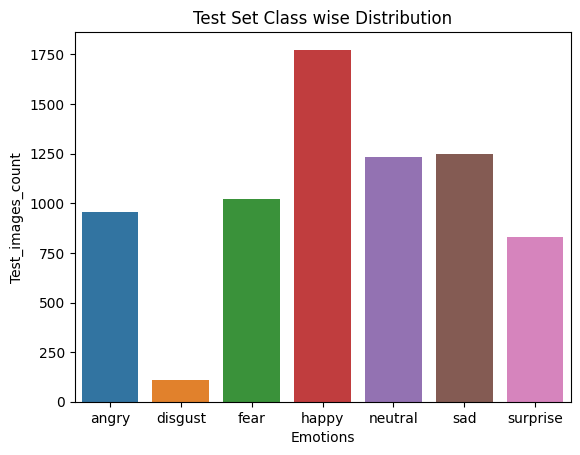

In [11]:
# Class wise distribution

import matplotlib
sns.barplot(x=df.Emotions,y=df.Train_images_count)
plt.title('Train Set Class wise Distribution')
plt.show()

plt.title('Test Set Class wise Distribution')
sns.barplot(x=df.Emotions,y=df.Test_images_count)
plt.show()

In [12]:
# There is a high class imbalance in Disgust alone
# Now solve the class imbalance using over sampling.

### Elimination of data imbalance

In [13]:
# Checking the count of each class
df

,Emotions,Train_images_count,Test_images_count
0,angry,3995,958
1,disgust,436,111
2,fear,4097,1024
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
6,surprise,3171,831


In [14]:
# getting the average of count other than disgust
avg = sum(df[df.Emotions!='disgust'].Train_images_count)/(len(df)-1)
avg

4712.166666666667

In [15]:
# Getting the ratio of the avg and disgust count
float(avg/df[df.Emotions=='disgust'].Train_images_count)

10.807721712538227

In [16]:
# As per the above statement the disgust has 10 times lesser image data than the average of other class data
# So lets oversample the data of this class atleast 8 times

shutil.copytree('./data/','./data_resampled/')

resample_train_path = './data_resampled/train/disgust/'
resample_test_path = './data_resampled/test/disgust/'

print('Resampling Train Data')
for a in range(1,4):
    files_list = sorted(os.listdir(resample_train_path))
    for file in range(0, len(files_list)):
        files = files_list[file] 
        shutil.copyfile(resample_train_path+files, resample_train_path+str(a)+files)  

print('Resampling Test Data')
        
for a in range(1,4):
    files_list = sorted(os.listdir(resample_test_path))
    for file in range(0, len(files_list)):
        files = files_list[file] 
        shutil.copyfile(resample_test_path+files, resample_test_path+str(a)+files)  

Resampling Train Data
Resampling Test Data


### Dataset visualization now after resampling

In [17]:
train_path ='./data_resampled/train/'
test_path ='./data_resampled/test/'

categories = os.listdir(train_path)

df_resampled = pd.DataFrame(categories,columns=['Emotions'])
train_count = []
test_count = []

for path in [train_path,test_path]: 
    for cat in categories:
        
        current_path = os.listdir(path+cat)
        if path == train_path:
            train_count.append(len(current_path))
            
        elif path == test_path:
            test_count.append(len(current_path))
            
df_resampled['Train_images_count'] = train_count
df_resampled['Test_images_count'] = test_count
display(df_resampled)

,Emotions,Train_images_count,Test_images_count
0,angry,3995,958
1,disgust,3488,888
2,fear,4097,1024
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
6,surprise,3171,831


### Function - Image data generator

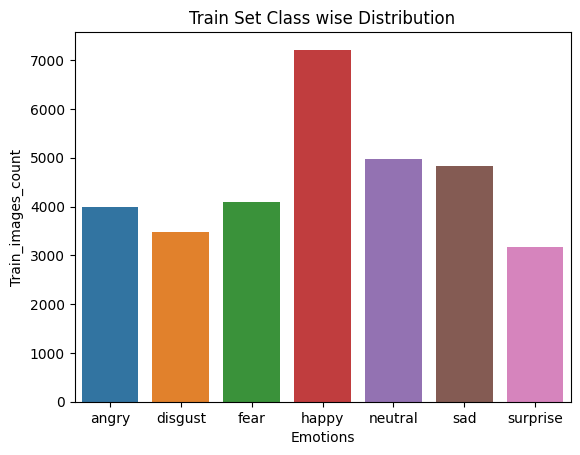

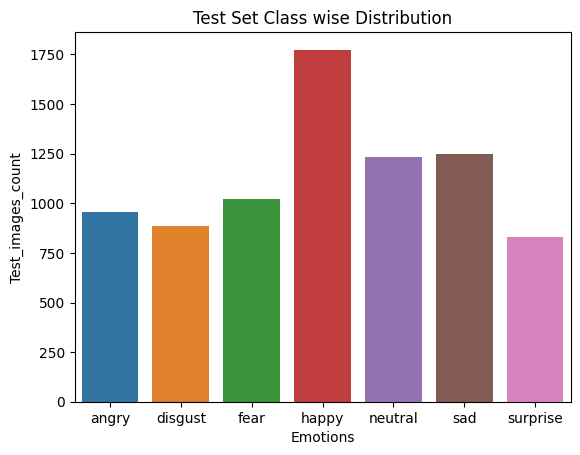

In [18]:
# Class wise distribution

sns.barplot(x=df_resampled.Emotions,y=df_resampled.Train_images_count)
plt.title('Train Set Class wise Distribution')
plt.show()

plt.title('Test Set Class wise Distribution')
sns.barplot(x=df_resampled.Emotions,y=df_resampled.Test_images_count)
plt.show()

### Image data generator

In [19]:
def image_generator(img_size,batch_size,color_mode,resampling=False):
    '''Pass the below mandatory values
        img_size = (img_height,img_width)
        batch_size : for train_generator
        and will return train_generator,val_generator,test_generator '''
    
    if resampling==False:
        train_path ='./data/train/'
        test_path ='./data/test/'
    else:
        train_path='./data_resampled/train'
        test_path='./data_resampled/test'

    train_img_generator = ImageDataGenerator(rescale=1./255,
                                            horizontal_flip=True,
                                            preprocessing_function=None,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            validation_split=0.2)

    train_generator = train_img_generator.flow_from_directory(
                        directory=train_path,
                        target_size=img_size,
                        batch_size=batch_size,
                        subset='training',
                        color_mode=color_mode)
    
    val_generator = train_img_generator.flow_from_directory(
                    directory=train_path,
                    target_size=img_size,
                    batch_size=batch_size,
                    subset='validation',
                    shuffle=False,
                    color_mode=color_mode)
    
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                        directory=test_path,
                                                        target_size=img_size,
                                                        batch_size=1,
                                                        shuffle=False,
                                                        color_mode = color_mode)
    return train_generator,val_generator,test_generator

### Functions - Model related

In [20]:
def compile_model(batch_size,img_size,model,optimizer,
                  loss='categorical_crossentropy',resampling=False,color_mode = 'grayscale'):
    '''
    returns train_generator,val_generator,test_generator,model'''
    train_generator,val_generator,test_generator = image_generator(img_size=img_size,color_mode=color_mode,batch_size=batch_size,resampling=resampling)
    model.compile(loss=loss,optimizer=optimizer,metrics=['categorical_accuracy','AUC'])
    display(model.summary())
    return train_generator,val_generator,test_generator,model

def fit_model(model,batch_size,train_generator,val_generator,
    epochs=25,early_stopping=False,filepath='Emotion_detection.h5'):
    
    model_chekpt = ModelCheckpoint(filepath=filepath,
                              verbose=1,
                               save_best_only=True,
                               monitor='val_loss',
                               mode='min')
    
    if early_stopping:
        early_stopping = EarlyStopping(patience=4, verbose=1, restore_best_weights=True, monitor='val_loss', mode='min')
        callbacks=[model_chekpt,early_stopping]
    else:
        callbacks = [model_chekpt]
        
    history = model.fit(train_generator,
                         verbose=1,
                         steps_per_epoch=train_generator.samples//batch_size,
                         epochs = epochs,
                        validation_data=val_generator,
                        validation_steps=val_generator.samples//batch_size,
                        callbacks=callbacks)
    return history

### Function for loss plot and Accuracy plot

In [21]:
def loss_plot(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def acc_plot(history):
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, train_acc, 'r', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()
    
def plot_results(history):
    loss_plot(history)
    acc_plot(history)

### Custom Model

In [ ]:
model=keras.Sequential()

model.add(keras.layers.Convolution2D(16,3,activation='relu',input_shape=(48, 48,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(32,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(64, 1, activation='relu'))                           
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Convolution2D(128,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(256,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(256, 1, activation='relu'))                           
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Convolution2D(256,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(256,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(128,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(128,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(7))
model.add(keras.layers.Activation('softmax'))

In [ ]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=64,img_size=(48,48),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=True)

In [ ]:
history = fit_model(model=model,batch_size=64,train_generator=train_generator,val_generator=val_generator)

In [ ]:
plot_results(history)

In [ ]:
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(7, activation='softmax'))

In [ ]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=64,img_size=(48,48),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=False)

In [ ]:
history = fit_model(model=model,batch_size=64,train_generator=train_generator,val_generator=val_generator)

In [ ]:
plot_results(history)

### Resnet50 Model Training

In [ ]:
from keras.applications import ResNet50

In [ ]:
resnet50 = ResNet50(include_top=False,input_shape=(224,224,3))
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

x = Dense(len(df),activation='softmax')(x)
model = Model(inputs=resnet50.input,outputs=x)

for layer in resnet50.layers:
    layer.trainable=False

In [ ]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=32,img_size=(224,224),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=False,
                                                                  color_mode='rgb')

In [ ]:
history = fit_model(model=model,batch_size=32,train_generator=train_generator,val_generator=val_generator)

In [ ]:
plot_results(history)

### Custom Model

In [22]:
model=keras.Sequential()

model.add(keras.layers.Convolution2D(16,3,activation='relu',input_shape=(48, 48,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(32,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(32, 3, activation='relu'))                           
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Convolution2D(64,5,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())                        

model.add(keras.layers.Convolution2D(128,5,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(256,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(256,5,activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(128,3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Convolution2D(64,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Convolution2D(32,3,activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(32))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(7))
model.add(keras.layers.Activation('softmax'))

In [23]:
train_generator,val_generator,test_generator,model = compile_model(batch_size=64,img_size=(48,48),model=model,
                                                                   optimizer=Adam(learning_rate=0.0001),resampling=True)

Found 25410 images belonging to 7 classes.
Found 6351 images belonging to 7 classes.
Found 7955 images belonging to 7 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46, 46, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                             

None

In [24]:
history = fit_model(model=model,batch_size=64,train_generator=train_generator,val_generator=val_generator,epochs=100)

Epoch 1/100
397/397 [==============================] - ETA: 0s - loss: 2.2371 - categorical_accuracy: 0.1826 - auc: 0.5469
Epoch 1: val_loss improved from inf to 2.01265, saving model to Emotion_detection.h5
397/397 [==============================] - 43s 87ms/step - loss: 2.2371 - categorical_accuracy: 0.1826 - auc: 0.5469 - val_loss: 2.0126 - val_categorical_accuracy: 0.1750 - val_auc: 0.5560
Epoch 2/100
397/397 [==============================] - ETA: 0s - loss: 2.0101 - categorical_accuracy: 0.2247 - auc: 0.5942
Epoch 2: val_loss improved from 2.01265 to 1.86466, saving model to Emotion_detection.h5
397/397 [==============================] - 33s 84ms/step - loss: 2.0101 - categorical_accuracy: 0.2247 - auc: 0.5942 - val_loss: 1.8647 - val_categorical_accuracy: 0.2554 - val_auc: 0.6280
Epoch 3/100
397/397 [==============================] - ETA: 0s - loss: 1.9653 - categorical_accuracy: 0.2399 - auc: 0.6137
Epoch 3: val_loss improved from 1.86466 to 1.80778, saving model to Emotion_det

397/397 [==============================] - 34s 85ms/step - loss: 1.1237 - categorical_accuracy: 0.5809 - auc: 0.8929 - val_loss: 1.1016 - val_categorical_accuracy: 0.5854 - val_auc: 0.8975
Epoch 22/100
397/397 [==============================] - ETA: 0s - loss: 1.1601 - categorical_accuracy: 0.5693 - auc: 0.8854
Epoch 22: val_loss did not improve from 1.10158
397/397 [==============================] - 34s 84ms/step - loss: 1.1601 - categorical_accuracy: 0.5693 - auc: 0.8854 - val_loss: 1.1540 - val_categorical_accuracy: 0.5795 - val_auc: 0.8886
Epoch 23/100
397/397 [==============================] - ETA: 0s - loss: 1.0892 - categorical_accuracy: 0.6001 - auc: 0.8997
Epoch 23: val_loss did not improve from 1.10158
397/397 [==============================] - 34s 84ms/step - loss: 1.0892 - categorical_accuracy: 0.6001 - auc: 0.8997 - val_loss: 1.1574 - val_categorical_accuracy: 0.5756 - val_auc: 0.8894
Epoch 24/100
397/397 [==============================] - ETA: 0s - loss: 1.1111 - categori

397/397 [==============================] - ETA: 0s - loss: 0.7991 - categorical_accuracy: 0.7035 - auc: 0.9465
Epoch 43: val_loss improved from 0.93279 to 0.92597, saving model to Emotion_detection.h5
397/397 [==============================] - 34s 86ms/step - loss: 0.7991 - categorical_accuracy: 0.7035 - auc: 0.9465 - val_loss: 0.9260 - val_categorical_accuracy: 0.6561 - val_auc: 0.9294
Epoch 44/100
397/397 [==============================] - ETA: 0s - loss: 0.7852 - categorical_accuracy: 0.7119 - auc: 0.9483
Epoch 44: val_loss did not improve from 0.92597
397/397 [==============================] - 34s 86ms/step - loss: 0.7852 - categorical_accuracy: 0.7119 - auc: 0.9483 - val_loss: 0.9697 - val_categorical_accuracy: 0.6465 - val_auc: 0.9232
Epoch 45/100
397/397 [==============================] - ETA: 0s - loss: 0.7776 - categorical_accuracy: 0.7151 - auc: 0.9494
Epoch 45: val_loss did not improve from 0.92597
397/397 [==============================] - 34s 85ms/step - loss: 0.7776 - cat

Epoch 66/100
397/397 [==============================] - ETA: 0s - loss: 0.6748 - categorical_accuracy: 0.7538 - auc: 0.9614
Epoch 66: val_loss did not improve from 0.91043
397/397 [==============================] - 34s 85ms/step - loss: 0.6748 - categorical_accuracy: 0.7538 - auc: 0.9614 - val_loss: 0.9440 - val_categorical_accuracy: 0.6763 - val_auc: 0.9320
Epoch 67/100
397/397 [==============================] - ETA: 0s - loss: 0.5910 - categorical_accuracy: 0.7877 - auc: 0.9704
Epoch 67: val_loss did not improve from 0.91043
397/397 [==============================] - 34s 85ms/step - loss: 0.5910 - categorical_accuracy: 0.7877 - auc: 0.9704 - val_loss: 0.9510 - val_categorical_accuracy: 0.6765 - val_auc: 0.9314
Epoch 68/100
397/397 [==============================] - ETA: 0s - loss: 0.5687 - categorical_accuracy: 0.7958 - auc: 0.9724
Epoch 68: val_loss did not improve from 0.91043
397/397 [==============================] - 34s 86ms/step - loss: 0.5687 - categorical_accuracy: 0.7958 - a

Epoch 89/100
397/397 [==============================] - ETA: 0s - loss: 0.3867 - categorical_accuracy: 0.8638 - auc: 0.9864
Epoch 89: val_loss did not improve from 0.91043
397/397 [==============================] - 34s 84ms/step - loss: 0.3867 - categorical_accuracy: 0.8638 - auc: 0.9864 - val_loss: 1.1536 - val_categorical_accuracy: 0.6640 - val_auc: 0.9157
Epoch 90/100
397/397 [==============================] - ETA: 0s - loss: 0.3898 - categorical_accuracy: 0.8639 - auc: 0.9862
Epoch 90: val_loss did not improve from 0.91043
397/397 [==============================] - 34s 84ms/step - loss: 0.3898 - categorical_accuracy: 0.8639 - auc: 0.9862 - val_loss: 1.1361 - val_categorical_accuracy: 0.6802 - val_auc: 0.9200
Epoch 91/100
397/397 [==============================] - ETA: 0s - loss: 0.3642 - categorical_accuracy: 0.8725 - auc: 0.9877
Epoch 91: val_loss did not improve from 0.91043
397/397 [==============================] - 34s 84ms/step - loss: 0.3642 - categorical_accuracy: 0.8725 - a

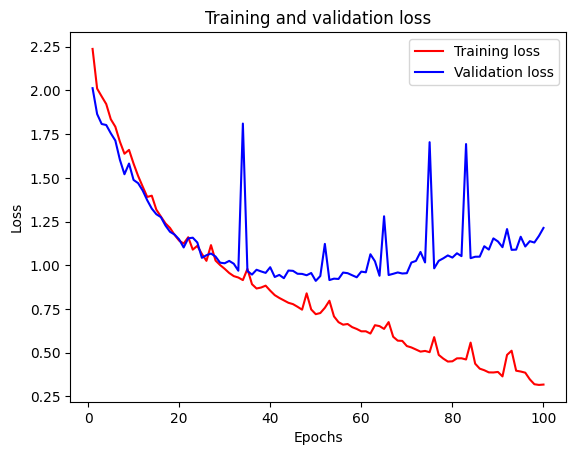

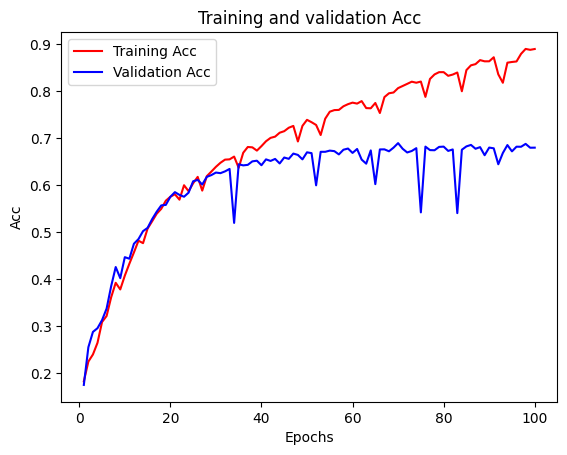

In [25]:
plot_results(history)